# Battles Cluster

This Jupyter Notebook is for cluster analysis. The goal is to find the best decks of the current season (in October 2021).

__Contents:__
1. Import libraries
2. Preparing data
3. Pre-processing
4. K-means cluster
5. K-modes cluster
6. Tuning model
7. Conclusion

## 1. Import libraries

In [1]:
pip install kmodes matplotlib_venn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from itertools import islice

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import _venn3, venn3, venn3_circles

## 2. Preparing data

In [3]:
df = pd.concat(
    map(pd.read_csv, ['ladder_battles_1.csv', 'ladder_battles_2.csv', 'ladder_battles_3.csv', 'ladder_battles.csv']), ignore_index=True)
df

,Unnamed: 0,gamemode,battletime,p1.name,p2.name,p1.crowns,p2.crowns,p1.card_1,p1.card_2,p1.card_3,...,p1.card_7,p1.card_8,p2.card_1,p2.card_2,p2.card_3,p2.card_4,p2.card_5,p2.card_6,p2.card_7,p2.card_8
0,0,Ladder,20211006T143711.000Z,Mattia™ 2,CoLoNeL Akam,2,1,Ice Golem,Hog Rider,Musketeer,...,Cannon,The Log,Giant,Balloon,Freeze,Skeletons,Minions,Minion Horde,Skeleton Army,Arrows
1,1,Ladder,20211006T134805.000Z,Mattia™ 2,♣️♦️Pedal♥️♠️,1,0,Ice Golem,Hog Rider,Musketeer,...,Cannon,The Log,Royal Recruits,Zappies,Fireball,The Log,Miner,Wall Breakers,Flying Machine,Elite Barbarians
2,2,Ladder,20211006T134339.000Z,Mattia™ 2,xV1ktoRx,1,0,Ice Golem,Hog Rider,Musketeer,...,Cannon,The Log,Mega Knight,Goblin Gang,Spear Goblins,Inferno Dragon,Miner,Skeleton Barrel,Zap,Bats
3,3,Ladder,20211006T132100.000Z,Mattia™ 2,ken,1,0,Ice Golem,Hog Rider,Musketeer,...,Cannon,The Log,P.E.K.K.A,Ram Rider,Bandit,Barbarian Barrel,Baby Dragon,Electro Wizard,Lightning,Giant Snowball
4,4,Ladder,20211006T131550.000Z,Mattia™ 2,Blazzer,0,1,Ice Golem,Hog Rider,Musketeer,...,Cannon,The Log,Lava Hound,Skeleton Dragons,Mega Minion,Barbarians,Flying Machine,Miner,Barbarian Hut,Arrows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,20,Ladder,20211013T164539.000Z,Regus,Nova I Hypno,1,0,Hog Rider,Musketeer,Ice Golem,...,Fireball,The Log,Goblin Barrel,Skeleton Barrel,Valkyrie,Skeleton Army,Princess,Dart Goblin,The Log,Inferno Tower
1189,21,Ladder,20211013T164020.000Z,Regus,Gus❤️Dlew,0,1,Hog Rider,Musketeer,Ice Golem,...,Fireball,The Log,Golem,Lumberjack,Wizard,Cannon Cart,Mini P.E.K.K.A,Zap,Electro Wizard,Arrows
1190,22,Ladder,20211013T163450.000Z,Regus,Ben061,2,1,Hog Rider,Musketeer,Ice Golem,...,Fireball,The Log,Lava Hound,Arrows,Barbarians,Miner,Inferno Dragon,Flying Machine,Baby Dragon,Goblin Cage
1191,23,Ladder,20211013T162930.000Z,Regus,wwwwwwww,1,0,Hog Rider,Musketeer,Ice Golem,...,Fireball,The Log,Mega Knight,Hog Rider,Inferno Dragon,Electro Wizard,Goblin Gang,Bats,Poison,Zap


All we need is the decks infomation.

In [4]:
# Only use the 8 cards of a deck from player 2
df = df[['p2.card_1', 'p2.card_2', 'p2.card_3', 'p2.card_4', 'p2.card_5', 'p2.card_6', 'p2.card_7', 'p2.card_8']]
df

,p2.card_1,p2.card_2,p2.card_3,p2.card_4,p2.card_5,p2.card_6,p2.card_7,p2.card_8
0,Giant,Balloon,Freeze,Skeletons,Minions,Minion Horde,Skeleton Army,Arrows
1,Royal Recruits,Zappies,Fireball,The Log,Miner,Wall Breakers,Flying Machine,Elite Barbarians
2,Mega Knight,Goblin Gang,Spear Goblins,Inferno Dragon,Miner,Skeleton Barrel,Zap,Bats
3,P.E.K.K.A,Ram Rider,Bandit,Barbarian Barrel,Baby Dragon,Electro Wizard,Lightning,Giant Snowball
4,Lava Hound,Skeleton Dragons,Mega Minion,Barbarians,Flying Machine,Miner,Barbarian Hut,Arrows
...,...,...,...,...,...,...,...,...
1188,Goblin Barrel,Skeleton Barrel,Valkyrie,Skeleton Army,Princess,Dart Goblin,The Log,Inferno Tower
1189,Golem,Lumberjack,Wizard,Cannon Cart,Mini P.E.K.K.A,Zap,Electro Wizard,Arrows
1190,Lava Hound,Arrows,Barbarians,Miner,Inferno Dragon,Flying Machine,Baby Dragon,Goblin Cage
1191,Mega Knight,Hog Rider,Inferno Dragon,Electro Wizard,Goblin Gang,Bats,Poison,Zap


**Load cards infomation**

In [5]:
cards = pd.read_csv('cards_basic.csv')
cards

,Card,Rarity,Type,Elixir Cost
0,Arrows,Common,Spell,3
1,Minions,Common,Troop,3
2,Archers,Common,Troop,3
3,Knight,Common,Troop,3
4,Fireball,Rare,Spell,4
...,...,...,...,...
98,Clone,Epic,Spell,3
99,Tornado,Epic,Spell,3
100,Cannon Cart,Epic,Troop,5
101,Mother Witch,Legendary,Troop,4


**Sort cards**

In [6]:
cat_type = pd.CategoricalDtype(['Troop', 'Building', 'Spell'], ordered=True)
cat_rarity = pd.CategoricalDtype(['Legendary', 'Epic', 'Rare', 'Common'], ordered=True)

cards['Type'] = cards['Type'].astype(cat_type)
cards['Rarity'] = cards['Rarity'].astype(cat_rarity)

cards_sorted = cards.sort_values(['Elixir Cost', 'Type', 'Rarity'], ascending=(False, True, True), ignore_index=True)
cards_sorted

,Card,Rarity,Type,Elixir Cost
0,Mirror,Epic,Spell,?
1,Three Musketeers,Rare,Troop,9
2,Golem,Epic,Troop,8
3,Electro Giant,Epic,Troop,8
4,Mega Knight,Legendary,Troop,7
...,...,...,...,...
98,Skeletons,Common,Troop,1
99,Fire Spirit,Common,Troop,1
100,Ice Spirit,Common,Troop,1
101,Electro Spirit,Common,Troop,1


**Order cards**

In [7]:
def order_cards(cards_list):
    
    cards_dict = dict(zip(cards_sorted['Card'], cards_sorted.index))
    
    cards_num = list()
    for card in cards_list:
        card_index = cards_dict.get(card)
        cards_num.append(card_index)
        
    ordered_cards = [card for _, card in sorted(zip(cards_num, cards_list))]
    
    return ordered_cards

In [8]:
for i in range(len(df.values)):
    df.values[i] = order_cards(df.values[i])

df

,p2.card_1,p2.card_2,p2.card_3,p2.card_4,p2.card_5,p2.card_6,p2.card_7,p2.card_8
0,Balloon,Giant,Minion Horde,Freeze,Skeleton Army,Minions,Arrows,Skeletons
1,Royal Recruits,Elite Barbarians,Flying Machine,Zappies,Fireball,Miner,Wall Breakers,The Log
2,Mega Knight,Inferno Dragon,Miner,Goblin Gang,Skeleton Barrel,Spear Goblins,Bats,Zap
3,P.E.K.K.A,Lightning,Ram Rider,Electro Wizard,Baby Dragon,Bandit,Barbarian Barrel,Giant Snowball
4,Lava Hound,Barbarian Hut,Barbarians,Flying Machine,Skeleton Dragons,Miner,Mega Minion,Arrows
...,...,...,...,...,...,...,...,...
1188,Inferno Tower,Valkyrie,Princess,Skeleton Army,Dart Goblin,Skeleton Barrel,Goblin Barrel,The Log
1189,Golem,Cannon Cart,Wizard,Electro Wizard,Lumberjack,Mini P.E.K.K.A,Arrows,Zap
1190,Lava Hound,Barbarians,Inferno Dragon,Baby Dragon,Flying Machine,Goblin Cage,Miner,Arrows
1191,Mega Knight,Inferno Dragon,Electro Wizard,Hog Rider,Poison,Goblin Gang,Bats,Zap


## 3. Pre-processing

In [9]:
# Convert into a flat list
flat_list = list()

for a in df.values:
    for item in a:
        flat_list.append(item)
        
len(flat_list)

9544

In [10]:
# Label list
le = LabelEncoder()
le.fit(flat_list)
labeled_list = le.transform(flat_list)
labeled_list

array([  3,  35,  65, ...,  66,  76, 101], dtype=int64)

**Label encoding**

In [11]:
# Rebuild DataFrame
labeled_df = np.array_split(labeled_list, (len(flat_list)/8))
labeled_df = pd.DataFrame(labeled_df)
labeled_df

,0,1,2,3,4,5,6,7
0,3,35,65,33,85,66,1,88
1,84,24,32,102,29,63,97,92
2,61,54,63,41,86,90,8,101
3,72,58,77,23,2,4,5,37
4,57,6,7,32,87,63,62,1
...,...,...,...,...,...,...,...,...
1188,55,96,75,85,18,86,38,92
1189,45,15,99,23,59,64,1,101
1190,57,7,54,2,32,39,63,1
1191,61,54,23,49,73,41,8,101


In [12]:
# Check the sum of cards
cards_sum = max(labeled_list) + 1
print(cards_sum == 103)

True


**One-hot encoding**

In [13]:
# Create a list containing `len(labeled_df)` lists, each of `cards_sum` items, all set to 0
list_0 = [[0 for x in range(cards_sum)] for y in range(len(labeled_df))]

# Turn each corresponding label to 1
for row in range(labeled_df.shape[0]):
    for col in range(labeled_df.shape[1]):
        list_0[row][labeled_df.iloc[row][col]] = 1
        
# Rebuild DataFrame
one_hot_df = pd.DataFrame(list_0)
one_hot_df

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1189,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1190,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1191,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## 4. K-means cluster

In [14]:
# Try to use K-means to find the best K
wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(one_hot_df)
    wcss.append(kmeans.inertia_)

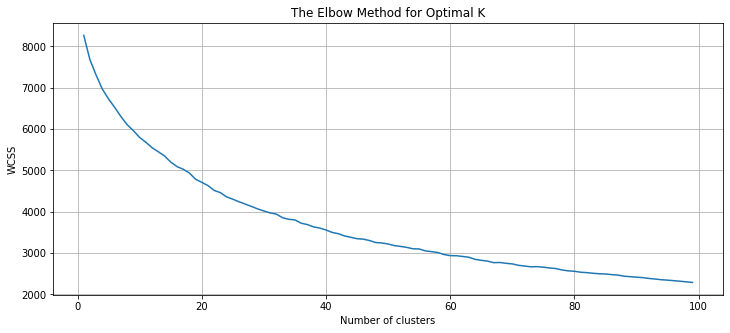

In [15]:
# Plot the WCSS with the K value
plt.figure(figsize=(12, 5))
plt.plot(range(1, 100), wcss)
plt.grid()
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It is hard to find the best number of clusters, suppose it is 30.

## 5. K-modes cluster

**Test K-modes**

In [16]:
# Try KModes
# Upfront specify the K=30
test = KModes(n_clusters=30, init='random', random_state=42)
test.fit_predict(one_hot_df)
test.cluster_centroids_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
test_card_numbers_list = list()

for centroid in range(len(test.cluster_centroids_)):
    for n_one in range(len(test.cluster_centroids_[centroid])):
        if test.cluster_centroids_[centroid][n_one] == 1:
            test_card_numbers_list.append(n_one)
            
len(test_card_numbers_list)

171

171 is Not equal to (8×30=)240. Not every cluster centroids have 8 cards.

In [18]:
test_one_numbers_list = list()

for centroid in test.cluster_centroids_:
    test_one_numbers_list.append(list(centroid).count(1))

test_one_numbers_list

[2,
 2,
 2,
 7,
 4,
 5,
 4,
 7,
 5,
 7,
 8,
 3,
 5,
 6,
 5,
 6,
 8,
 7,
 8,
 8,
 7,
 8,
 7,
 6,
 5,
 8,
 7,
 3,
 8,
 3]

And Not all cluster centroids have the same shape.

In [19]:
test_it = iter(test_card_numbers_list)
test_slice_list = [list(islice(test_it, 0, i)) for i in test_one_numbers_list]
test_slice_list

[[3, 5],
 [29, 92],
 [1, 85],
 [18, 38, 74, 75, 78, 79, 92],
 [2, 5, 39, 95],
 [1, 4, 23, 54, 61],
 [8, 54, 61, 101],
 [11, 29, 63, 90, 92, 96, 97],
 [7, 29, 49, 66, 101],
 [38, 41, 55, 56, 75, 79, 92],
 [14, 29, 49, 51, 52, 70, 88, 92],
 [29, 39, 83],
 [3, 29, 54, 57, 101],
 [4, 5, 23, 37, 72, 77],
 [4, 5, 24, 48, 81],
 [24, 65, 85, 95, 99, 101],
 [4, 10, 23, 29, 60, 72, 81, 101],
 [5, 15, 29, 32, 34, 43, 69],
 [8, 17, 29, 41, 42, 74, 90, 101],
 [22, 29, 31, 62, 69, 82, 88, 92],
 [4, 5, 29, 54, 59, 60, 77],
 [1, 32, 39, 47, 57, 62, 63, 87],
 [23, 24, 29, 31, 69, 72, 101],
 [24, 41, 62, 74, 87, 88],
 [79, 88, 91, 92, 96],
 [17, 23, 24, 42, 62, 76, 89, 101],
 [19, 30, 49, 88, 91, 92, 96],
 [38, 85, 96],
 [17, 23, 29, 35, 62, 63, 74, 101],
 [35, 65, 85]]

**Convert numbers to cards**

In [20]:
test_card_names_list = list()

for card_numbers in test_slice_list:
    test_card_names_list.append(order_cards(le.inverse_transform(card_numbers)))
    
test_card_names_list

[['Balloon', 'Barbarian Barrel'],
 ['Fireball', 'The Log'],
 ['Skeleton Army', 'Arrows'],
 ['Rocket',
  'Prince',
  'Rascals',
  'Princess',
  'Dart Goblin',
  'Goblin Barrel',
  'The Log'],
 ['Baby Dragon', 'Goblin Cage', 'Tornado', 'Barbarian Barrel'],
 ['Mega Knight', 'Inferno Dragon', 'Electro Wizard', 'Bandit', 'Arrows'],
 ['Mega Knight', 'Inferno Dragon', 'Bats', 'Zap'],
 ['Valkyrie',
  'Bomb Tower',
  'Fireball',
  'Miner',
  'Wall Breakers',
  'Spear Goblins',
  'The Log'],
 ['Barbarians', 'Hog Rider', 'Fireball', 'Minions', 'Zap'],
 ['Rocket',
  'Inferno Tower',
  'Princess',
  'Knight',
  'Goblin Gang',
  'Goblin Barrel',
  'The Log'],
 ['Musketeer',
  'Hog Rider',
  'Fireball',
  'Cannon',
  'Ice Golem',
  'The Log',
  'Skeletons',
  'Ice Spirit'],
 ['Royal Hogs', 'Goblin Cage', 'Fireball'],
 ['Lava Hound', 'Balloon', 'Inferno Dragon', 'Fireball', 'Zap'],
 ['P.E.K.K.A',
  'Ram Rider',
  'Electro Wizard',
  'Bandit',
  'Barbarian Barrel',
  'Giant Snowball'],
 ['Elite Barbari

**Use win conditions**

We only consider decks with win conditions to be robust. 

In [21]:
win_conditions = pd.read_csv('win_conditions.csv')
win_conditions

,Win Conditions
0,Mortar
1,Lava Hound
2,Goblin Giant
3,Three Musketeers
4,Royal Hogs
5,Royal Giant
6,Miner
7,Graveyard
8,Golem
9,Battle Ram


In [22]:
test_win_conditions_list = list()

for deck in test_card_names_list:
    if any(x in win_conditions.values for x in deck):
        test_win_conditions_list.append(deck)
        
test_win_conditions_list

[['Balloon', 'Barbarian Barrel'],
 ['Rocket',
  'Prince',
  'Rascals',
  'Princess',
  'Dart Goblin',
  'Goblin Barrel',
  'The Log'],
 ['Valkyrie',
  'Bomb Tower',
  'Fireball',
  'Miner',
  'Wall Breakers',
  'Spear Goblins',
  'The Log'],
 ['Barbarians', 'Hog Rider', 'Fireball', 'Minions', 'Zap'],
 ['Rocket',
  'Inferno Tower',
  'Princess',
  'Knight',
  'Goblin Gang',
  'Goblin Barrel',
  'The Log'],
 ['Musketeer',
  'Hog Rider',
  'Fireball',
  'Cannon',
  'Ice Golem',
  'The Log',
  'Skeletons',
  'Ice Spirit'],
 ['Royal Hogs', 'Goblin Cage', 'Fireball'],
 ['Lava Hound', 'Balloon', 'Inferno Dragon', 'Fireball', 'Zap'],
 ['P.E.K.K.A',
  'Ram Rider',
  'Electro Wizard',
  'Bandit',
  'Barbarian Barrel',
  'Giant Snowball'],
 ['P.E.K.K.A',
  'Electro Wizard',
  'Magic Archer',
  'Battle Ram',
  'Fireball',
  'Royal Ghost',
  'Bandit',
  'Zap'],
 ['Goblin Giant',
  'Prince',
  'Dark Prince',
  'Fireball',
  'Goblin Gang',
  'Spear Goblins',
  'Bats',
  'Zap'],
 ['Royal Giant',
  'Mo

**Find prototypes**

Now let's filter out the real decks with 8 cards.

In [23]:
test_prototypes_list = list()

for deck in sorted(test_win_conditions_list):
    if len(deck) == 8:
        test_prototypes_list.append(deck)
        
test_prototypes_list

[['Goblin Giant',
  'Prince',
  'Dark Prince',
  'Fireball',
  'Goblin Gang',
  'Spear Goblins',
  'Bats',
  'Zap'],
 ['Lava Hound',
  'Flying Machine',
  'Skeleton Dragons',
  'Goblin Cage',
  'Miner',
  'Guards',
  'Mega Minion',
  'Arrows'],
 ['Musketeer',
  'Hog Rider',
  'Fireball',
  'Cannon',
  'Ice Golem',
  'The Log',
  'Skeletons',
  'Ice Spirit'],
 ['P.E.K.K.A',
  'Electro Wizard',
  'Magic Archer',
  'Battle Ram',
  'Fireball',
  'Royal Ghost',
  'Bandit',
  'Zap'],
 ['Prince',
  'Giant',
  'Electro Wizard',
  'Dark Prince',
  'Fireball',
  'Miner',
  'Mega Minion',
  'Zap'],
 ['Royal Giant',
  'Mother Witch',
  'Fireball',
  'Fisherman',
  'Mega Minion',
  'The Log',
  'Skeletons',
  'Electro Spirit'],
 ['Sparky',
  'Goblin Giant',
  'Elite Barbarians',
  'Electro Wizard',
  'Dark Prince',
  'Mega Minion',
  'Rage',
  'Zap']]

## 6. Tuning model

According to the steps above, we create a function.

In [24]:
# Define function to convert one_hot numbers to final decks
def prototypes(cluster_centroids):
    
    prototypes_list = list()
    
    # Convert binary values to card names
    # Step 1: convert binary values to card numbers
    card_numbers_list = list()
    for centroid in range(len(cluster_centroids)):
        for n_one in range(len(cluster_centroids[centroid])):
            if cluster_centroids[centroid][n_one] == 1:
                card_numbers_list.append(n_one)
    
    # Create a list for slicing
    one_numbers_list = list()
    for centroid in cluster_centroids:
        one_numbers_list.append(list(centroid).count(1))
    
    # Slice `card_numbers_list
    it = iter(card_numbers_list)
    slice_list = [list(islice(it, 0, i)) for i in one_numbers_list]
    
    # Step 2: convert card numbers to card names
    card_names_list = list()
    for card_numbers in slice_list:
        card_names_list.append(order_cards(le.inverse_transform(card_numbers)))
    
    # Only conserve decks with "Win Condictions"
    win_conditions_list = list()
    for deck in card_names_list:
        if any(x in win_conditions.values for x in deck):
            win_conditions_list.append(deck)
            
    # Only conserve decks with 8 cards
    for deck in sorted(win_conditions_list):
        if len(deck) == 8:
            prototypes_list.append(deck)
            
    return prototypes_list

Run a total of 100 clusters.

In [25]:
prototypes_sum = list()
prototypes_df = pd.DataFrame(columns=['Clusters number', 'Deck'])

cost = []
K = range(1, 100)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init='random', random_state=42)
    kmode.fit_predict(one_hot_df)
    cost.append(kmode.cost_)
    
    prototypes_list = prototypes(kmode.cluster_centroids_)
    prototypes_sum.append(len(prototypes_list))
    
    for deck in prototypes_list:
        prototypes_df.loc[len(prototypes_df)] = [num_clusters, deck]

In [26]:
prototypes_df.to_csv('deck_prototypes.csv')
prototypes_df

,Clusters number,Deck
0,10,"[Royal Recruits, Royal Hogs, Flying Machine, Z..."
1,12,"[Musketeer, Hog Rider, Fireball, Cannon, Ice G..."
2,13,"[Lava Hound, Balloon, Barbarians, Inferno Drag..."
3,13,"[Musketeer, Hog Rider, Fireball, Cannon, Ice G..."
4,14,"[Lava Hound, Balloon, Barbarians, Inferno Drag..."
...,...,...
1988,99,"[Three Musketeers, Elixir Collector, Hunter, R..."
1989,99,"[Valkyrie, Goblin Drill, Tesla, Fireball, Wall..."
1990,99,"[Valkyrie, Hog Rider, Tesla, Firecracker, Eart..."
1991,99,"[X-Bow, Rocket, Valkyrie, Tesla, Ice Wizard, T..."


**Plot to find the best number of clusters**

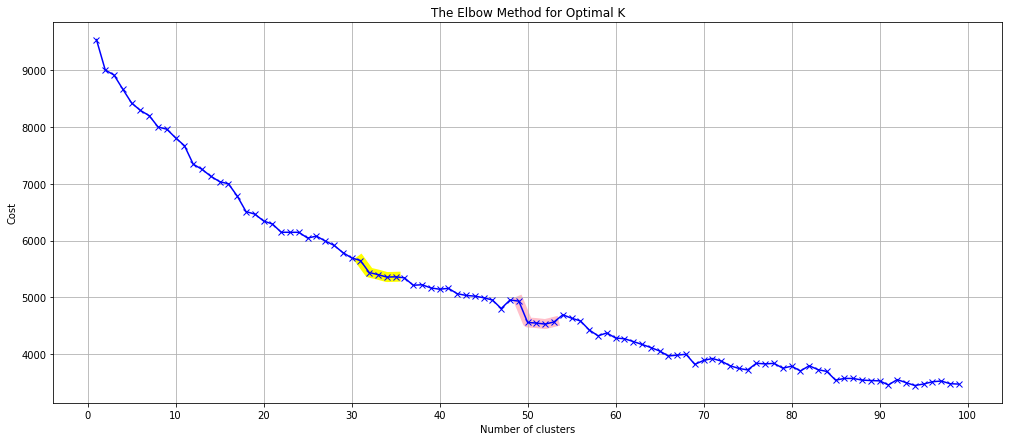

In [27]:
plt.figure(figsize=(17, 7))
plt.plot(K, cost, 'bx-')
plt.plot(K[30:35], cost[30:35], lw=10, c='yellow', zorder=-1)
plt.plot(K[48:53], cost[48:53], lw=10, c='pink', zorder=-1)
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 101, 10))
plt.ylabel('Cost')
plt.grid()
plt.show()

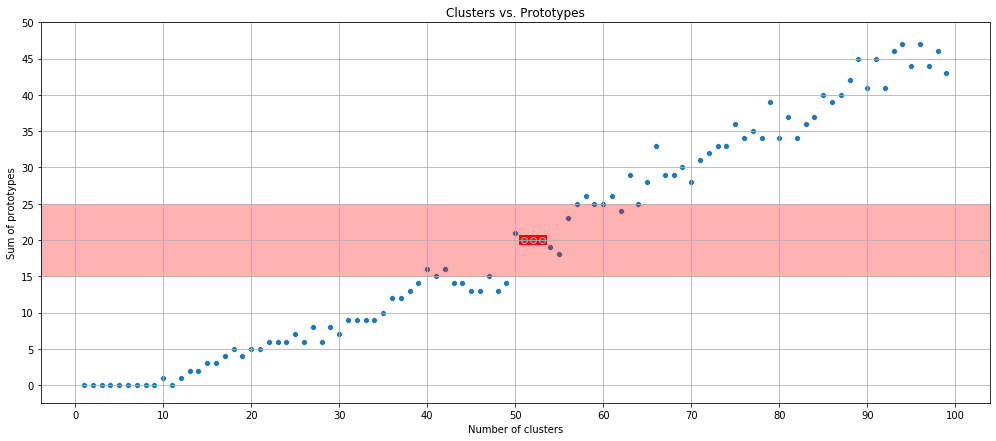

In [28]:
plt.figure(figsize=(17, 7))
plt.axhspan(15, 25, color='red', alpha=0.3)
fig = sns.scatterplot(K, prototypes_sum)
plt.plot(K[50:53], prototypes_sum[50:53], lw=10, c='red', zorder=-1)
plt.title('Clusters vs. Prototypes')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 101, 10))
plt.ylabel('Sum of prototypes')
plt.yticks(np.arange(0, 51, 5))
plt.grid()
plt.show(fig)

The "Cost" and "Sum of prototypes" trade-off shows that one of [50, 51, 52] is the optimal number, let's find out.

In [30]:
pd.set_option('display.max_colwidth', 500)
prototypes_51 = prototypes_df[prototypes_df['Clusters number']==51]
prototypes_51

,Clusters number,Deck
356,51,"[Balloon, Electro Dragon, Bowler, Inferno Dragon, Lumberjack, Freeze, Tornado, Barbarian Barrel]"
357,51,"[Bomb Tower, Fireball, Miner, Knight, Wall Breakers, Spear Goblins, Bats, The Log]"
358,51,"[Cannon Cart, Minion Horde, Mortar, Fireball, Miner, Goblin Gang, Spear Goblins, The Log]"
359,51,"[Electro Giant, Lightning, Inferno Dragon, Mother Witch, Dark Prince, Goblin Cage, Tornado, Bomber]"
360,51,"[Elite Barbarians, Electro Dragon, Inferno Dragon, Night Witch, Battle Healer, Elixir Golem, Arrows, Rage]"
361,51,"[Goblin Giant, Prince, Dark Prince, Fireball, Goblin Gang, Spear Goblins, Bats, Zap]"
362,51,"[Golem, Electro Dragon, Cannon Cart, Lumberjack, Baby Dragon, Mega Minion, Tornado, Barbarian Barrel]"
363,51,"[Lava Hound, Balloon, Barbarians, Inferno Dragon, Skeleton Dragons, Miner, Arrows, Zap]"
364,51,"[Lava Hound, Flying Machine, Skeleton Dragons, Goblin Cage, Miner, Guards, Mega Minion, Arrows]"
365,51,"[Magic Archer, Valkyrie, Bomb Tower, Miner, Tornado, Wall Breakers, Spear Goblins, The Log]"


In [31]:
prototypes_52 = prototypes_df[prototypes_df['Clusters number']==52]
prototypes_52

,Clusters number,Deck
376,52,"[Balloon, Electro Dragon, Bowler, Inferno Dragon, Lumberjack, Freeze, Tornado, Barbarian Barrel]"
377,52,"[Bomb Tower, Fireball, Miner, Knight, Wall Breakers, Spear Goblins, Bats, The Log]"
378,52,"[Cannon Cart, Minion Horde, Mortar, Fireball, Miner, Goblin Gang, Spear Goblins, The Log]"
379,52,"[Goblin Giant, Prince, Dark Prince, Fireball, Goblin Gang, Spear Goblins, Bats, Zap]"
380,52,"[Lava Hound, Balloon, Barbarians, Inferno Dragon, Skeleton Dragons, Miner, Arrows, Zap]"
381,52,"[Lava Hound, Flying Machine, Skeleton Dragons, Goblin Cage, Miner, Guards, Mega Minion, Arrows]"
382,52,"[Magic Archer, Valkyrie, Bomb Tower, Miner, Tornado, Wall Breakers, Spear Goblins, The Log]"
383,52,"[Mega Knight, Balloon, Hunter, Miner, Fisherman, Mega Minion, Tombstone, Arrows]"
384,52,"[Mega Knight, Sparky, Prince, Wizard, Inferno Dragon, Skeleton Army, Skeleton Barrel, Fire Spirit]"
385,52,"[Musketeer, Hog Rider, Fireball, Cannon, Ice Golem, The Log, Skeletons, Ice Spirit]"


In [32]:
prototypes_53 = prototypes_df[prototypes_df['Clusters number']==53]
prototypes_53

,Clusters number,Deck
396,53,"[Balloon, Electro Dragon, Bowler, Inferno Dragon, Lumberjack, Freeze, Tornado, Barbarian Barrel]"
397,53,"[Bomb Tower, Fireball, Miner, Knight, Wall Breakers, Spear Goblins, Bats, The Log]"
398,53,"[Cannon Cart, Minion Horde, Mortar, Fireball, Miner, Goblin Gang, Spear Goblins, The Log]"
399,53,"[Electro Giant, Lightning, Inferno Dragon, Mother Witch, Dark Prince, Goblin Cage, Tornado, Bomber]"
400,53,"[Goblin Giant, Prince, Dark Prince, Fireball, Goblin Gang, Spear Goblins, Bats, Zap]"
401,53,"[Golem, Electro Dragon, Cannon Cart, Lumberjack, Baby Dragon, Mega Minion, Tornado, Barbarian Barrel]"
402,53,"[Lava Hound, Balloon, Barbarians, Inferno Dragon, Skeleton Dragons, Miner, Arrows, Zap]"
403,53,"[Lava Hound, Flying Machine, Skeleton Dragons, Goblin Cage, Miner, Guards, Mega Minion, Arrows]"
404,53,"[Magic Archer, Valkyrie, Bomb Tower, Miner, Tornado, Wall Breakers, Spear Goblins, The Log]"
405,53,"[Mega Knight, Balloon, Hunter, Miner, Fisherman, Mega Minion, Tombstone, Arrows]"


**Make decision using the Venn diagram**

In [40]:
subsets_raw = _venn3.compute_venn3_subsets(set([tuple(x) for x in prototypes_51.Deck]), 
                                       set([tuple(x) for x in prototypes_52.Deck]), 
                                       set([tuple(x) for x in prototypes_53.Deck]))
subsets_raw

(1, 2, 0, 0, 2, 1, 17)

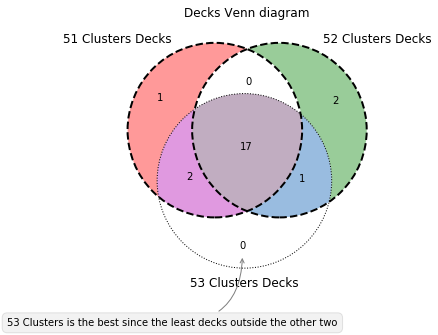

In [70]:
# Add 10 to each of the first 6 unbalanced numbers for a nicer diagram
subsets_plot = (11, 12, 10, 10, 12, 11, 17)
bit_counter = ('100', '010', '110', '001', '101', '011', '111')

plt.figure(figsize=(5,5))
v = venn3(subsets=subsets_plot, 
          set_labels = ('A', 'B', 'C'))
for i in range(7):
    if subsets_raw[i]==0:
        v.get_patch_by_id(bit_counter[i]).set_alpha(1.0)
        v.get_patch_by_id(bit_counter[i]).set_color('white')
        
    v.get_label_by_id(bit_counter[i]).set_text(subsets_raw[i])
    
v.get_label_by_id('A').set_text('51 Clusters Decks')
v.get_label_by_id('B').set_text('52 Clusters Decks')
v.get_label_by_id('C').set_text('53 Clusters Decks')

c = venn3_circles(subsets=subsets_plot, linestyle='dashed')
c[2].set_lw(1.0)
c[2].set_ls('dotted')
plt.title('Decks Venn diagram')
plt.annotate('53 Clusters is the best since the least decks outside the other two', 
             xy=v.get_label_by_id('001').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

## 7. Conclusion

We find the __`53`__ is the best number of clusters. The __best decks__ of the current season (S28 "Shocktober") are as follows:

- [LumberLoon Double Dragon Bowler Freeze](https://royaleapi.com/decks/stats/balloon,barbarian-barrel,bowler,electro-dragon,freeze,inferno-dragon,lumberjack,tornado)
- [WB Miner Bats 2.8 Cycle](https://royaleapi.com/decks/stats/bats,bomb-tower,fireball,knight,miner,spear-goblins,the-log,wall-breakers)
- [Mortar Miner Horde Cart](https://royaleapi.com/decks/stats/cannon-cart,fireball,goblin-gang,miner,minion-horde,mortar,spear-goblins,the-log)
- [EGiant DP ID MW](https://royaleapi.com/decks/stats/bomber,dark-prince,electro-giant,goblin-cage,inferno-dragon,lightning,mother-witch,tornado)
- [GobG Double Prince Bats Bait](https://royaleapi.com/decks/stats/bats,dark-prince,fireball,goblin-gang,goblin-giant,prince,spear-goblins,zap)
- [Golem Double Dragon Cart Nado](https://royaleapi.com/decks/stats/baby-dragon,barbarian-barrel,cannon-cart,electro-dragon,golem,lumberjack,mega-minion,tornado)
- [LavaLoon Miner Double Dragon](https://royaleapi.com/decks/stats/arrows,balloon,barbarians,inferno-dragon,lava-hound,miner,skeleton-dragons,zap)
- [LH Miner SD FM](https://royaleapi.com/decks/stats/arrows,flying-machine,goblin-cage,guards,lava-hound,mega-minion,miner,skeleton-dragons)
- [WB Miner MA Valk](https://royaleapi.com/decks/stats/bomb-tower,magic-archer,miner,spear-goblins,the-log,tornado,valkyrie,wall-breakers)
- [Loon MK FishBoy Hunter](https://royaleapi.com/decks/stats/arrows,balloon,fisherman,hunter,mega-knight,mega-minion,miner,tombstone)
- [MK Prince Wiz ID](https://royaleapi.com/decks/stats/fire-spirit,inferno-dragon,mega-knight,prince,skeleton-army,skeleton-barrel,sparky,wizard)
- [Hog 2.6 Cycle](https://royaleapi.com/decks/stats/cannon,fire-spirit,fireball,hog-rider,ice-golem,musketeer,skeletons,the-log)
- [Pekka Bandit EWiz Bridge Spam](https://royaleapi.com/decks/stats/bandit,battle-ram,electro-wizard,magic-archer,pekka,poison,royal-ghost,zap)
- [Giant Double Prince EWiz](https://royaleapi.com/decks/stats/dark-prince,electro-wizard,fireball,giant,mega-minion,miner,prince,zap)
- [RamRider Bandit ID MA](https://royaleapi.com/decks/stats/bandit,barbarian-barrel,fireball,ice-golem,inferno-dragon,lumberjack,magic-archer,ram-rider)
- [RG FishBoy MW 3.0 Cycle](https://royaleapi.com/decks/stats/electro-spirit,fireball,fisherman,mega-minion,mother-witch,royal-giant,skeletons,the-log)
- [RG FishBoy Hunter 3.1 Cycle](https://royaleapi.com/decks/stats/electro-spirit,fireball,fisherman,hunter,mother-witch,royal-giant,skeletons,the-log)
- [GobG EBarbs EWiz Rage](https://royaleapi.com/decks/stats/dark-prince,electro-wizard,elite-barbarians,goblin-giant,mega-minion,rage,sparky,zap)
- [3M Bandit Ghost Hunter](https://royaleapi.com/decks/stats/bandit,barbarian-barrel,elixir-collector,heal-spirit,hunter,ice-golem,royal-ghost,three-musketeers)
- [Hog Valk FC 2.8 Cycle](https://royaleapi.com/decks/stats/earthquake,fire-spirit,firecracker,hog-rider,skeletons,tesla,the-log,valkyrie)